In [11]:
from sklearn.datasets import load_files
import numpy as np
import keras.utils as np_utils
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import matplotlib.pyplot as plt
from keras.models import load_model
import h5py
%matplotlib inline
plt.style.use("fivethirtyeight")

The goal of this tutorial is to look at how we could perform Transfer Learning using already existing, powerful models (inspiration from Francois Chollet's [excellent tutorial](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)). We can also learn a few Keras tricks on the way and explore visualization of CNN filters and activations! The data comes from Kaggle's competition [Dogs vs Cats](https://www.kaggle.com/c/dogs-vs-cats) that was launched a few years ago. To keep it in line with the the tutorial, download the data from the Kaggle website and then run the ```file_structure.py``` script.

# Simple approach with data augmentation

The idea here is that we can perform data augmentation both to get more trainning examples, but also to avoid overfitting. This will slightly change we use Keras compared to scenarios with no data augmentation.

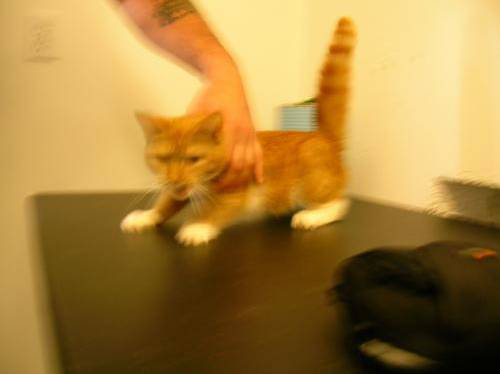

In [2]:
# Let's take a look at some image samples
cat_img = load_img("data/new_format/train/cats/cat.0.jpg")
cat_img

In [3]:
# convert to array
img_ar = img_to_array(cat_img)
print(img_ar.shape) # note that not all images are consistent in terms of pixel dimensions and they are in rgb
img_ar[:2]

(374, 500, 3)


array([[[ 203.,  164.,   87.],
        [ 203.,  164.,   87.],
        [ 204.,  165.,   88.],
        ..., 
        [ 240.,  201.,  122.],
        [ 239.,  200.,  121.],
        [ 238.,  199.,  120.]],

       [[ 203.,  164.,   87.],
        [ 203.,  164.,   87.],
        [ 204.,  165.,   88.],
        ..., 
        [ 241.,  202.,  123.],
        [ 240.,  201.,  122.],
        [ 238.,  199.,  120.]]], dtype=float32)

In [4]:
datagen = ImageDataGenerator(
        rotation_range=40, # max degree of rotation for the image
        width_shift_range=0.2, # max fraction along x axis to perform shift
        height_shift_range=0.2, # max fraction along y axis to perform shift
        rescale=1./255, # 
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

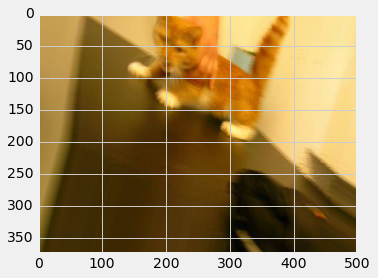

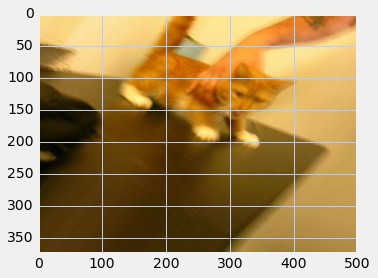

In [5]:
# let's see the types of images that will be generated now
i = 0

for batch in datagen.flow(img_ar.reshape((1,)+img_ar.shape), batch_size=1):
    plt.imshow(batch[0])
    i+=1
    plt.show()
    if i==2:
        break


# Attempt #1, a humble conv-net

Now that we have done our data preprocessing, it is time to see how well a simple convnet would do!

In [17]:
from keras.models import Sequential
from keras.layers import MaxPooling2D, Activation, Conv2D, Flatten, Dense, Dropout

simple_model = Sequential()

# Layer 1
simple_model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3), activation="relu"))
simple_model.add(MaxPooling2D(pool_size=(2,2)))

# Layer 2
simple_model.add(Conv2D(32, (3, 3), activation="relu"))
simple_model.add(MaxPooling2D(pool_size=(2,2)))

# Layer 3
simple_model.add(Conv2D(64, (3, 3), activation="relu"))
simple_model.add(MaxPooling2D(pool_size=(2,2)))

# Add some FC layers here and then a binary head
simple_model.add(Flatten()) # You can do some fancier stuff like Global Average Pooling (GAP)
simple_model.add(Dense(64, activation="relu"))
simple_model.add(Dropout(0.5)) # dropout with retention probability of 0.5
simple_model.add(Dense(1, activation="sigmoid"))

simple_model.summary() # Notice that we have A LOT of trainable parameters. All these are probably introduced by the FC layers

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 18496)             0         
__________

In [18]:
from keras.optimizers import Adam

# Time for some model trainning

opt = Adam() # Adam is usually the go to since it combines the best of RMSProp and Adadelta

simple_model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

batch_size = 16
n_epochs = 50

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# technically we are not doing any permutations, just rescaling our validation images
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'data/new_format/train',  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        'data/new_format/validation',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')

Found 20473 images belonging to 2 classes.
Found 4527 images belonging to 2 classes.


In [ ]:
from keras.callbacks import ModelCheckpoint


# To keep track of the best model
checkpointer = ModelCheckpoint(filepath='models/simple_cnn_best.h5', 
                               verbose=1, save_best_only=True, monitor="val_loss")

history = simple_model.fit_generator(
        train_generator,
        steps_per_epoch=2000 // batch_size,
        epochs=n_epochs,
        validation_data=validation_generator,
        validation_steps=800 // batch_size,
        callbacks=[checkpointer])

In [98]:
simple_cnn = load_model("models/simple_cnn_best.h5")